# consema on Polyps data

- Author: Luca Mossina. IRT Saint Exupéry, Toulouse, France

**Scope**: test the full pipeline for Conformal Prediction on Polyps data and PraNet predictions (via repos of `aangelopoulos`)

- data: Polyps
- predictor: PraNet as pre-computed by `aangelopoulos` [(link to repo)](https://github.com/aangelopoulos/conformal-prediction/blob/67f506e4880e192ef9fc6a2de73e21b277f8c544/notebooks/tumor-segmentation.ipynb)
- nonconformity score: thresholding, n. of dilations, radius of structuring element
- generation of dataset: https://github.com/aangelopoulos/conformal-prediction/blob/67f506e4880e192ef9fc6a2de73e21b277f8c544/generation-scripts/generate-polyps.py#L56

**REMARK**: if we want to be able to plot prediction, ground-truth masks and the input images, we must restrict our attention to the 500 samples in `data[example_indexes]`.(see below).
They were sampled randomly without replacement (see link above `generation of dataset`).

Hence, we should be able to safely split the example in two parts, one for calibration and the other for testing.

In [ ]:
from dotenv import load_dotenv
import torch
import matplotlib.pyplot as plt
from consema.conformal import Conformalizer
import numpy as np
import os
from consema.morphology import (
    operator_dilation_sequential,
    operator_dilation_disk_radius,
)

device_str = "cpu"

RANDOM_SEED = 42

## Setup data, predictors and predictions

In [ ]:
def setup_polyps(random_seed: int, cal_test_ratio: float):
    # load data as downloaded from gdrive
    load_dotenv()

    POLYPS_NPZ = os.getenv("POLYPS_NPZ")

    data = np.load(f"{POLYPS_NPZ}/polyps-pranet.npz")
    sgmd = data["sgmd"]  # sigmoid scores

    gt_masks = data["targets"]
    test_calib_idxs = [elem.item() for elem in data["example_indexes"]]

    # Rescale sigmoid scores to [0, 1] for each image
    sgmd_rescaled = np.array(
        [(img - img.min()) / (img.max() - img.min()) for img in sgmd]
    )
    sgmd = sgmd_rescaled

    np.random.seed(random_seed)
    np.random.shuffle(test_calib_idxs)

    split_num = int(len(test_calib_idxs) * cal_test_ratio)
    calib_idxs = test_calib_idxs[:split_num]
    test_idxs = test_calib_idxs[split_num:]

    assert set(calib_idxs).isdisjoint(
        set(test_idxs)
    ), "calib and test sets are not disjoint"

    n_samples = len(calib_idxs)
    print(f"{n_samples = }")

    # return sgmd, gt_masks, calib_idxs, test_idxs
    from skimage.transform import resize

    calib_pred_arrays = sgmd[calib_idxs]
    calib_gt_arrays = gt_masks[calib_idxs]
    calib_input_img_paths = [
        f"{POLYPS_NPZ}/examples/" + str(rnd_idx_) + ".jpg"
        for rnd_idx_ in test_calib_idxs
    ]
    calib_images = [plt.imread(img_path_) for img_path_ in calib_input_img_paths]

    calib_gt_img_paths = [
        f"{POLYPS_NPZ}/examples/" + str(rnd_idx_) + "_gt_mask.jpg"
        for rnd_idx_ in test_calib_idxs
    ]
    calib_gt_imgs = [plt.imread(img_path_) for img_path_ in calib_gt_img_paths]

    calib_preds_resized = [
        resize(pred, (img.shape[0], img.shape[1]), anti_aliasing=False)
        for pred, img in zip(calib_pred_arrays, calib_images)
    ]
    calib_gt_resized = [
        resize(gt, (img.shape[0], img.shape[1]), anti_aliasing=False)
        for gt, img in zip(calib_gt_arrays, calib_images)
    ]

    # DO_TEST = False
    DO_TEST = True

    if DO_TEST:
        test_pred_arrays = sgmd[test_idxs]
        test_gt_arrays = gt_masks[test_idxs]
        test_input_img_paths = [
            f"{POLYPS_NPZ}/examples/" + str(rnd_idx_) + ".jpg" for rnd_idx_ in test_idxs
        ]
        test_images = [plt.imread(img_path_) for img_path_ in test_input_img_paths]

        test_gt_img_paths = [
            f"{POLYPS_NPZ}/examples/" + str(rnd_idx_) + "_gt_mask.jpg"
            for rnd_idx_ in test_idxs
        ]
        test_gt_imgs = [plt.imread(img_path_) for img_path_ in test_gt_img_paths]

        test_preds_resized = [
            resize(pred, (img.shape[0], img.shape[1]), anti_aliasing=False)
            for pred, img in zip(test_pred_arrays, test_images)
        ]
        test_gt_resized = [
            resize(gt, (img.shape[0], img.shape[1]), anti_aliasing=False)
            for gt, img in zip(test_gt_arrays, test_images)
        ]
    else:
        test_images = []
        test_gt_arrays = []
        test_pred_arrays = []
        test_preds_resized = []
        test_gt_resized = []

    # add a dummy dimenstion for batch size (== 1)
    calib_pred_arrays = [np.expand_dims(pred, 0) for pred in calib_pred_arrays]
    calib_gt_arrays = [np.expand_dims(gt, 0) for gt in calib_gt_arrays]
    calib_preds_resized = [np.expand_dims(pred, 0) for pred in calib_preds_resized]
    calib_gt_resized = [np.expand_dims(gt, 0) for gt in calib_gt_resized]
    calib_images = [np.expand_dims(img, 0) for img in calib_images]

    if DO_TEST:
        test_pred_arrays = [np.expand_dims(pred, 0) for pred in test_pred_arrays]
        test_gt_arrays = [np.expand_dims(gt, 0) for gt in test_gt_arrays]
        test_preds_resized = [np.expand_dims(pred, 0) for pred in test_preds_resized]
        test_gt_resized = [np.expand_dims(gt, 0) for gt in test_gt_resized]
        test_images = [np.expand_dims(img, 0) for img in test_images]
    else:
        test_images = []
        test_gt_arrays = []
        test_pred_arrays = []
        test_preds_resized = []
        test_gt_resized = []

    return (
        calib_images,
        calib_gt_arrays,
        calib_pred_arrays,
        test_images,
        test_gt_arrays,
        test_pred_arrays,
    )


(
    calib_images,
    calib_gt_arrays,
    calib_pred_arrays,
    test_images,
    test_gt_arrays,
    test_pred_arrays,
) = setup_polyps(RANDOM_SEED, 0.5)

n_samples = 250


### Visualize False Negatives: we want to control their quantity

Via conformal prediction, we control how many false negative we will have, on average, in our test inferences (e.g. when deployed in production)

In [ ]:
from consema.plots import visualize_false_negatives

In [ ]:
calib_images[0].shape

(1, 288, 384, 3)

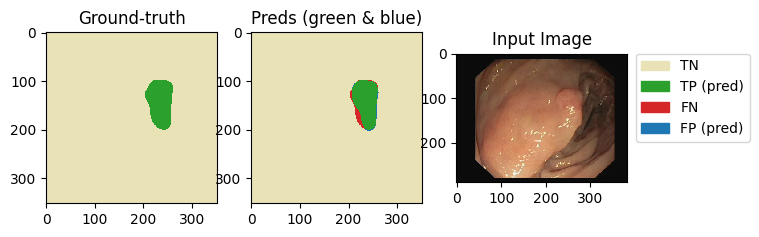

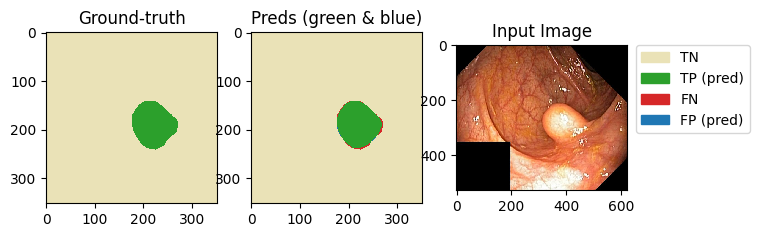

In [ ]:
for it, (image, prediction, gt) in enumerate(
    zip(calib_images, calib_pred_arrays, calib_gt_arrays)
):
    if it >= 2:
        break
    visualize_false_negatives(image[0], gt[0], prediction[0] > 0.5)

In the figure above, the **red points** are false negatives, that is, points that belong to the ground-truth masks but were not predicted by the algorithm.

Using conformal prediction, we want to "extend" the prediction area (in green) with a conformal margin so that we limit our prediction errors, that is, we reduce the number of false negative with high probability at a significance level chosen by the user.

The price to pay are more false positives: in this case, we can imagine that false positives push the users to be more conservative and they are "safe" errors.

If there are too many false positives, then the prediction becomes operationally useless; this tradeoff is controlled by the user and their predictive model: worse models will have more false negatives, hence larger conformal margins. 

In [ ]:
from consema.morphology import (
    dilation_metrics,
)
from consema.conformal import thresholding_score
from consema.plots import plot_margin_and_recovered, visualize_false_negatives

In [ ]:
idx_ = 100
bintruth = calib_gt_arrays[idx_] > 0.5
binpred = calib_pred_arrays[idx_] > 0.5
softpred = calib_pred_arrays[idx_]

cov_threshold = 0.999

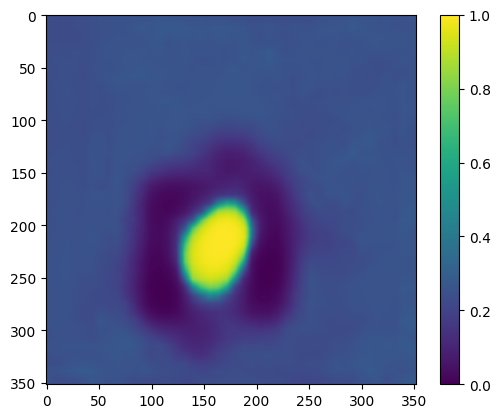

In [ ]:
plt.imshow(softpred[0])
plt.colorbar()
plt.show()

### Thresholding nonconformity score

Sources:
- LAC (Least Ambiguous Set-Valued Classifiers), [Sadinle et al. (2019)](https://arxiv.org/abs/1609.00451)
- CRC (Conformal Risk Control), [Angelopoulos et al. (2022)](https://arxiv.org/abs/2208.02814)

**Thresholding the softmax** or sigmoid scores for **classification** follows from the theory developed in Sadinle et al. (2019), where they work with generic probability distribution, not specifically with neural networks. In this case, the probability estimates (e.g. softmax scores) are known to be not calibrated, and some properties (e.g. optimal size of prediction sets) do not necessarily hold. 

As for **binary image segmentation** with an underlying pixel-wise classifier, this was introduced as an application of their CRC algorithm by Angelopoulos et al. (2022): they do not explicitly mention nonconformity scores, although it follows immediately from their definition of risk and computation of $\hat{\lambda}$, for the case of binary (conformal) losses.

In [ ]:
nc_threshold = thresholding_score(
    gt_mask_=bintruth,
    soft_pred_mask_=softpred,
    # se_params_=se_params,
    coverage_threshold=cov_threshold,
)

from consema.morphology import operator_thresholding

dilated_threshold_mask = operator_thresholding(
    softpred[0], nc_threshold, se_params_=None
)

print(f"{nc_threshold = :.9f}")
metrics = dilation_metrics(dilated_threshold_mask[0], binpred[0])
print(f" --- THRESH: n. added px = {metrics[0]}, stretch = {metrics[1]}")

coverage_tensor = np.multiply(dilated_threshold_mask, bintruth)
coverage = np.sum(coverage_tensor) / np.count_nonzero(bintruth)
print(f"{coverage = :.9f}")

nc_threshold = 0.728079744
 --- THRESH: n. added px = -4308, stretch = 0.0
coverage = 0.829492004


In [ ]:
dilated_threshold_mask.shape

(352, 352)

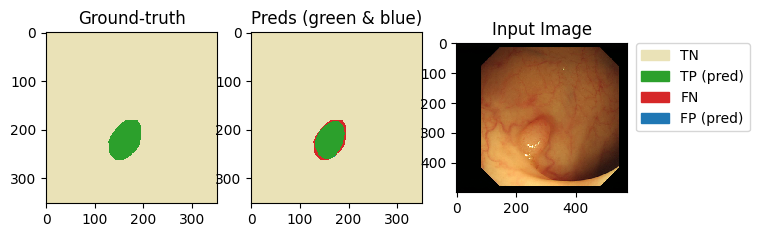

In [ ]:
visualize_false_negatives(calib_images[idx_][0], bintruth[0], dilated_threshold_mask)

No pixels were recovered


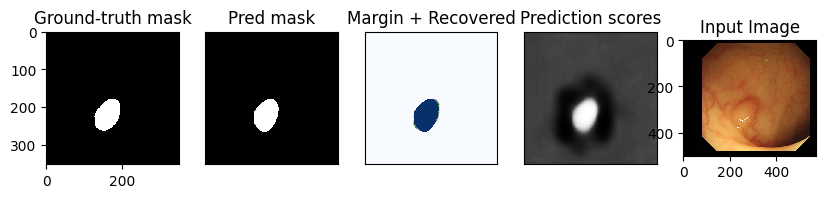

In [ ]:
plot_margin_and_recovered(
    binpred[0],
    bintruth[0],
    dilated_threshold_mask[0],
    plot_hard_margin=False,
    figsize=(11, 5),
    input_image=calib_images[idx_][0],
    softprediction=softpred[0],
)

### Morphological prediction sets: dilation

This is part of the original contribution of the paper: building statistically valid prediction sets under minimal information.
- No softmax/sigmoid scores necessary
- usable on blackbox predictor, e.g. hidden behind API, MLaaS, etc.
- only need a small dataset of labeled, production-like data to measure uncertainty
- literature available: mathematical morphology for computer vision (without deep learning)

I introduce two cases:
- (3x3) structuring element, either square or cross: iteratively dilate the mask as dilated at previous iterations until $\tau \times 100 \%$ of the ground-truth pixels are recovered. Applying several dilations (or other) is also known as **depth** of the dilation. This will constitue the nonconformity score, the higher the worse the prediction was.
- variable-size disk: as above, but only apply one dilation to the predicted mask, with the radius of the disk increasing at each iteration

In [ ]:
from consema.morphology import (
    dilation_score_variable_disk,
    dilation_score_fixed_disk,
)

se_params = dict(strict_radius=True)  # [3 X 3] cross
# se_params = dict(strict_radius=False)  # [3 X 3] square

#### Iterative dilations

Nonconcormity score = depth, or number of repeated dilations.
- Using fixed-size structuring element

nc_fixed = 4
 ---  FIXED: n. added px = 899, stretch = 1.2086815227483751


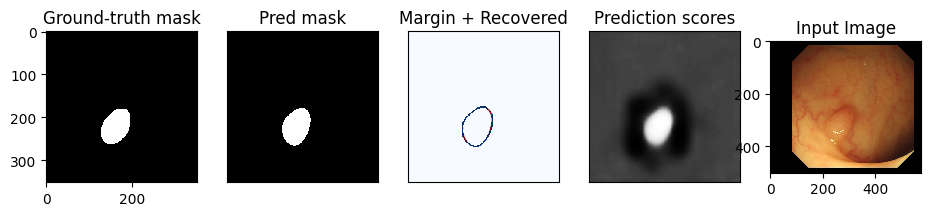

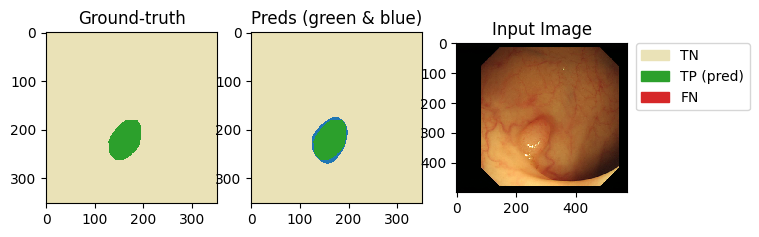

In [ ]:
## 1. Fixed disk
# nc_fixed, dilated_mask_fixed = dilation_score_fixed_disk(
nc_fixed = dilation_score_fixed_disk(
    gt_mask_=bintruth[0],
    pred_mask_=binpred[0],
    se_params_=se_params,
    coverage_threshold=cov_threshold,
)
print(f"{nc_fixed = }")


dilated_mask_fixed = operator_dilation_sequential(
    input_mask=binpred[0], operator_parameter=nc_fixed, se_params_=se_params
)
metrics = dilation_metrics(dilated_mask_fixed, binpred[0])
print(f" ---  FIXED: n. added px = {metrics[0]}, stretch = {metrics[1]}")
plot_margin_and_recovered(
    binpred[0],
    bintruth[0],
    dilated_mask_fixed,
    input_image=calib_images[idx_][0],
    softprediction=softpred[0],
)
visualize_false_negatives(calib_images[idx_][0], bintruth[0], dilated_mask_fixed)

#### Variable-size disk as structuring element

Instead of repeating dilations incrementally, on can obtain a similar results modifying the radius of the structuring element used for dilations.

Computationally, it should be worse than fixed-size for big radii: a naive implementation requires a number a computations that grows quadratically with the size (H x W) of the structuring element.

For binary dilations (our case), one can use a convolution followed by a max: this can be a good option if working directly with torch and tensors; with large images, we could expect comp. gains via gpus.

nc_variable = 3


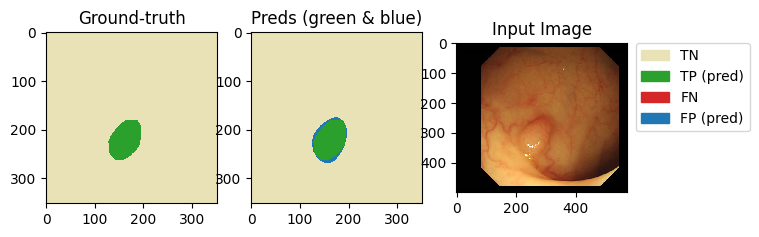

 ---  VARIA: n. added px = 707, stretch = 1.164113277623027


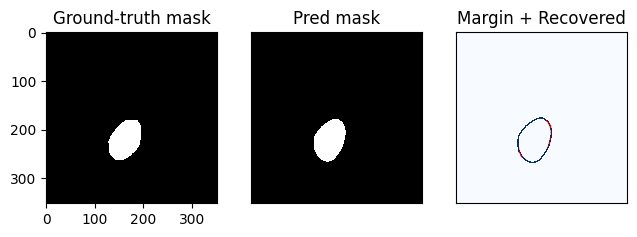

In [ ]:
## 2. Variable disk
nc_variable = dilation_score_variable_disk(
    gt_mask_=bintruth[0],
    pred_mask_=binpred[0],
    se_params_=se_params,
    coverage_threshold=cov_threshold,
)

print(f"{nc_variable = }")

dilated_mask_variable = operator_dilation_disk_radius(
    input_mask=binpred[0], operator_parameter=nc_variable, se_params_=se_params
)

visualize_false_negatives(calib_images[idx_][0], bintruth[0], dilated_mask_variable)

metrics = dilation_metrics(dilated_mask_variable, binpred[0])
print(f" ---  VARIA: n. added px = {metrics[0]}, stretch = {metrics[1]}")
plot_margin_and_recovered(binpred[0], bintruth[0], dilated_mask_variable)

---

## Conformal loop: compute scores and quantiles

Conformal prediction (CP) is usually presented as a predictive method to build statistically valid prediction sets (or intervals) that will contain, with high probability, the true value of a target $Y$ being predicted by some ML model as $\hat{Y} = \hat{f}(X)$; the features X could be tabular data, images, etc.

However, we have another useful piece of information: the actual errors (nonconformity scores), their size, their distribution.
CP can also be used as a diagnostic tool: the users choose a score (or make their own), a tolerable risk level, and then they could:
- compare several architectures, trained on the same data: the one with the smallest scores (and prediction set) could be preferable to another with slightly better performance metrics (precision, mAP, etc.)
- interpret the errors: in production, how and where the model errs.
- interpret the size and shape of the prediction set: for regression or classification, this is the width and cardinality or pred. sets. For segmentation or object detection, this could be the size of the conformal margins, etc.

### Visualize margin: use a gradient to show successive dilations and recovered pixels

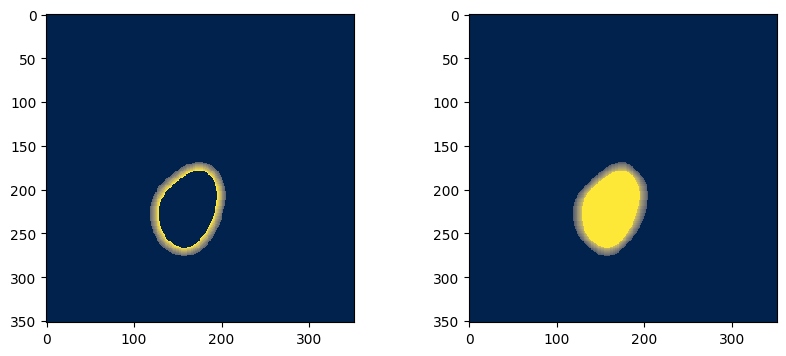

In [ ]:
from consema.plots import margin_gradient_visu

margin_var = margin_gradient_visu(
    binpred[0], "variable_disk", 10, None, False, se_params
)
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].imshow(margin_var, cmap="cividis", interpolation="none")
margin_fixed = margin_gradient_visu(binpred[0], "fixed_disk", 10, None, True, se_params)
ax[1].imshow(margin_fixed, cmap="cividis", interpolation="none")
plt.show()

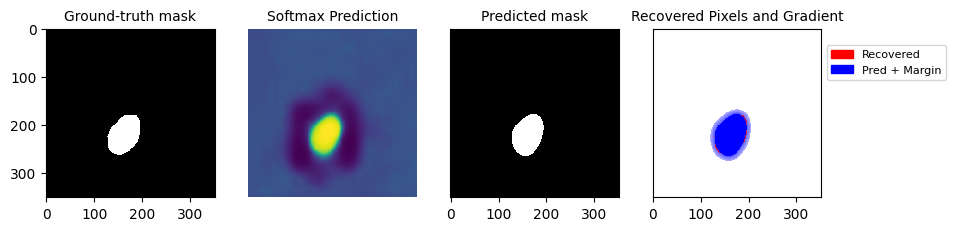

In [ ]:
from matplotlib.patches import Patch
from consema.conformal import recovered_pixels_bin_array

_grad = margin_gradient_visu(binpred[0], "variable_disk", 10, 20, True, se_params)

# Assuming _grad is your H x W array
H, W = _grad.shape
rgba_image = np.zeros((H, W, 4), dtype=np.uint8)  # Create an RGBA array

# Normalize the gradient to the range [0, 1]
normalized_grad = _grad / np.max(_grad)

# Set all pixels that are non-zero in the recovered mask to red with full opacity
recovered = recovered_pixels_bin_array(bintruth[0], binpred[0], dilated_mask_variable)

# Define blending factor and colors
alpha_blend = 0.7  # Controls red intensity (0 = no red, 1 = fully red)

# Assign colors: white for zeros, blue for non-zero entries
nonmargin_indices = np.where(_grad > 0)
rgba_image[..., 0] = (1 - normalized_grad) * 255  # Red channel
rgba_image[..., 1] = (1 - normalized_grad) * 255  # Green channel
rgba_image[..., 2] = 255  # Blue channel
rgba_image[..., 3] = (normalized_grad * 255).astype(
    np.uint8
)  # Alpha channel (transparency)

# Blend red for recovered pixels
recovered_indices = np.where(recovered == 1)
rgba_image[recovered_indices] = (
    alpha_blend * np.array([255, 0, 0, 255])  # Red with full opacity
    + (1 - alpha_blend) * rgba_image[recovered_indices]
).astype(np.uint8)

# Visualize the RGBA image
fig, ax = plt.subplots(1, 4, figsize=(10, 5))

# Plot ground truth mask on the left
ax[0].imshow(bintruth[0], cmap="gray", interpolation="none")
ax[0].set_title("Ground-truth mask", fontsize=10)
# ax[0].axis("off")

# Plot softmax prediction
ax[1].imshow(softpred[0], cmap="viridis", interpolation="none")
ax[1].set_title("Softmax Prediction", fontsize=10)
ax[1].axis("off")

# plot hard predicted mask
ax[2].imshow(binpred[0], cmap="gray", interpolation="none")
# ax[2].imshow(binpred[0], cmap="Greens", interpolation="none")
ax[2].set_title("Predicted mask", fontsize=10)
ax[2].get_yaxis().set_visible(False)

# Plot RGBA image on the right
ax[3].imshow(rgba_image, interpolation="none")
ax[3].set_title("Recovered Pixels and Gradient", fontsize=10)
ax[3].get_yaxis().set_visible(False)

legend_elements = [
    Patch(facecolor="red", edgecolor="red", label="Recovered"),
    Patch(facecolor="blue", edgecolor="blue", label="Pred + Margin"),
]

ax[3].legend(
    handles=legend_elements, fontsize=8, loc="center left", bbox_to_anchor=(1, 0.8)
)
plt.show()

### Setup conformalizer

In [ ]:
from benchmarkerie.models import PranetPolypsPrecomputedInferencer

inferencer = PranetPolypsPrecomputedInferencer(device=device_str)

### Setup conformal parameters
- `covratio` $\in (0,1)$ (coverage ratio): how many ground-truth pixels must be covered in each image to be considered a success
- `alpha` $ \in (0,1)$ (nominal risk): on average, how many inferences can be wrong (but we don't say by how much)

During conformalization, the nonconformity scores tell
- how many dilations, or 
- how big the structuring element (e.g. disk), or
- which threshold $\in (0,1)$

was necessary to achieve the specified `covratio`. If `covratio = 1`, then 100% of the ground-truth pixels must be captured.

In [ ]:
data_calib = tuple(
    (img, gt, softpred)
    for img, gt, softpred in zip(calib_images, calib_gt_arrays, calib_pred_arrays)
)

data_test = tuple(
    (img, gt, softpred)
    for img, gt, softpred in zip(test_images, test_gt_arrays, test_pred_arrays)
)

In [ ]:
score_funcs = ["fixed_disk", "variable_disk", "thresholding"]

se_params = dict(strict_radius=True)  # [3 X 3] cross
# se_params = dict(strict_radius=False)  # [3 X 3] square

configs = [
    dict(
        chosen_nc_score=score_funcs[0],
        covratio=0.99,
        alpha=0.1,
        se_params=se_params,
    ),
    dict(
        chosen_nc_score=score_funcs[2],
        covratio=0.99,
        alpha=0.1,
        se_params=se_params,
    ),
]

conformers = []

In [ ]:
print(f" --- n calibration points: {len(data_calib)}")

cp_quantiles = []

for cfg in configs:
    cpred = Conformalizer(
        inferencer=inferencer,
        nonconformity_function_name=cfg["chosen_nc_score"],
        structuring_element_params=cfg["se_params"],
    )

    confo_resu = cpred.compute_nonconformity_scores(data_calib, cfg["covratio"])

    conformalizing_quantile = cpred.get_conformal_quantile(cfg["alpha"])
    print(f"{conformalizing_quantile = }")
    cp_quantiles.append(conformalizing_quantile)

    # is_thresholding = chosen_nc_score == "thresholding"
    # # cpred.plot_nc_scores(alpha_risk=alpha, threshold_score=is_thresholding)
    # # cpred.plot_nc_scores_frequency(alpha=alpha)

    test_predictions = cpred.test_inferences(data_test)
    test_results = cpred.test_conformalization(
        test_predictions, cfg["alpha"], cfg["covratio"]
    )

    empirical_coverage = np.mean(test_results.conformal_tests)
    empirical_covratio = np.mean(test_results.empirical_covratios)
    empirical_avg_add_pixels = np.mean(test_results.added_pixels)
    empirical_avg_stretch = np.mean(test_results.stretch_factors)

    print(
        f" --- cov : {empirical_coverage:.4f} vs nominal : {1-cfg['alpha']}, for num elements: {len(test_results.conformal_tests)}"
    )
    print(f" --- {empirical_avg_add_pixels = :.4f}")
    print(f" --- {empirical_avg_stretch = :.4f}")

    conformers.append((cpred, test_predictions, test_results))

 --- n calibration points: 250
conformalizing_quantile = 28
 --- cov : 0.9440 vs nominal : 0.9, for num elements: 250
 --- empirical_avg_add_pixels = 13853.7520
 --- empirical_avg_stretch = 2.2488
conformalizing_quantile = 0.7582317478320153
 --- cov : 0.9160 vs nominal : 0.9, for num elements: 250
 --- empirical_avg_add_pixels = 70602.5960
 --- empirical_avg_stretch = 12.4051


In [ ]:
## func to plot Fig.2 in paper

from typing import Optional


def fig_plot_margin_and_recovered(
    predicted_mask: np.ndarray,
    ground_truth_mask: np.ndarray,
    dilated_mask: np.ndarray,
    input_image: Optional[np.ndarray] = None,
    softprediction: Optional[np.ndarray] = None,
    plot_hard_margin: Optional[bool] = False,
    figsize: Optional[tuple] = None,
    save_cp_method_name: Optional[str] = None,
    save_indivdual_plots: Optional[bool] = False,
):
    import matplotlib.pyplot as plt
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    if isinstance(predicted_mask, torch.Tensor):
        predicted_mask = predicted_mask.cpu().numpy()
    if isinstance(ground_truth_mask, torch.Tensor):
        ground_truth_mask = ground_truth_mask.cpu().numpy()
    if isinstance(dilated_mask, torch.Tensor):
        dilated_mask = dilated_mask.cpu().numpy()

    nplots = 4
    if input_image is not None:
        nplots += 1
    if softprediction is not None:
        nplots += 1

    margin = np.logical_xor(dilated_mask, predicted_mask)

    # ## for readability in paper, crop the image.
    # ## DANGER: assumes there is nothing going on in this region
    # crop = 1  # 15
    # ground_truth_mask = ground_truth_mask[crop:-crop, crop:-crop]
    # predicted_mask = predicted_mask[crop:-crop, crop:-crop]
    # dilated_mask = dilated_mask[crop:-crop, crop:-crop]
    # margin = margin[crop:-crop, crop:-crop]

    # ## do not crop input image, soft pred
    # # if input_image is not None:
    # #     input_image = input_image[crop:-crop, crop:-crop]

    recovered = np.where(
        (ground_truth_mask == 1) & (predicted_mask == 0) & (dilated_mask == 1), 1, 0
    )
    not_recovered = np.where(
        (ground_truth_mask == 1) & (predicted_mask == 0) & (dilated_mask == 0), 666, 0
    )

    if recovered.sum() == 0:
        print("No pixels were recovered")
        # return

    recovered_rgba = np.zeros((*recovered.shape, 4))
    # (X,X,X,1) for 1 with full opacity
    recovered_rgba[recovered == 1] = [1, 0, 0, 1]
    recovered_rgba[recovered == 0] = [0, 0, 0, 0]  # Transparent for value 0
    recovered_rgba[not_recovered == 666] = [0, 100 / 255, 0, 1]

    if plot_hard_margin:
        margin = np.where(margin > 0, 1, 0)

    figsize = (5 * nplots, 6)
    fig, axes = plt.subplots(1, nplots, figsize=figsize, dpi=200)

    ## === (1) Ground-truth mask
    gt_color = np.array((216, 27, 96)) / 255
    gt_rgba = np.zeros((*ground_truth_mask.shape, 4))
    gt_rgba[ground_truth_mask == 1] = [gt_color[0], gt_color[1], gt_color[2], 1]
    gt_rgba[ground_truth_mask == 0] = [1, 1, 1, 1]  # White for value 0

    axes[0].imshow(gt_rgba, interpolation="none")
    axes[0].set_title(r"Ground-truth mask $Y$")
    axes[0].set_xticks([])
    axes[0].set_yticks([])

    ## === (2) Predicted mask
    pred_color = np.array((30, 136, 229)) / 255
    pred_rgba = np.zeros((*predicted_mask.shape, 4))
    pred_rgba[predicted_mask == 1] = [pred_color[0], pred_color[1], pred_color[2], 0.75]
    pred_rgba[predicted_mask == 0] = [1, 1, 1, 1]  # White for value 0

    axes[1].imshow(pred_rgba, interpolation="none")
    axes[1].set_title(r"Predicted mask $\hat{Y}$")
    axes[1].set_xticks([])
    axes[1].set_yticks([])

    ## === (3) Intersection of gt and pred: intersection in true_pos_color, the others as gt or pred respectively
    true_pos_color = np.array((120, 94, 240)) / 255
    intersection_rgba = np.zeros((*ground_truth_mask.shape, 4))
    intersection_rgba[(ground_truth_mask == 1) & (predicted_mask == 1)] = [
        true_pos_color[0],
        true_pos_color[1],
        true_pos_color[2],
        0.8,
    ]
    # false negative in gt_color
    intersection_rgba[(ground_truth_mask == 1) & (predicted_mask == 0)] = [
        gt_color[0],
        gt_color[1],
        gt_color[2],
        1,
    ]
    # false positive in pred_color
    intersection_rgba[(ground_truth_mask == 0) & (predicted_mask == 1)] = [
        pred_color[0],
        pred_color[1],
        pred_color[2],
        0.75,
    ]

    axes[2].imshow(intersection_rgba, interpolation="none")
    axes[2].set_title(r"Intersection: $Y \cap \hat{Y}$")
    axes[2].set_xticks([])
    axes[2].set_yticks([])

    ## === (4) Dilated mask:
    ## pred_mask in "gainsboro", margin in pred_color with alpha=0.5, recovered in orange with hatching
    recov_color = np.array((254, 97, 0)) / 255
    dilated_rgba = np.zeros((*dilated_mask.shape, 4))
    dilated_rgba[margin == 1] = [pred_color[0], pred_color[1], pred_color[2], 0.5]
    dilated_rgba[recovered == 1] = [recov_color[0], recov_color[1], recov_color[2], 1]
    # dilated_rgba[predicted_mask == 1] = [0.86, 0.86, 0.86, 1]
    dilated_rgba[predicted_mask == 1] = [
        true_pos_color[0],
        true_pos_color[1],
        true_pos_color[2],
        0.8,
    ]

    axes[3].imshow(dilated_rgba, interpolation="none")
    axes[3].set_title(f"Margin ({save_cp_method_name}) in light blue")
    axes[3].set_xticks([])
    axes[3].set_yticks([])

    ## if input_image is not None, plot it
    if input_image is not None:
        axes[4].imshow(input_image, cmap="Greys_r", interpolation="none")
        axes[4].set_title("Input image")
        axes[4].set_xticks([])
        axes[4].set_yticks([])
        # axes[4].set_xlabel("Input image")
        ## if softprediction is not None, plot it
        if softprediction is not None:
            im = axes[5].imshow(softprediction, cmap="viridis", interpolation="none")
            axes[5].set_xticks([])
            axes[5].set_yticks([])
            axes[5].set_title("Soft prediction (sigmoid)")
            divider = make_axes_locatable(axes[5])
            cax = divider.append_axes("right", size="5%", pad=0.05)
            cbar = fig.colorbar(im, cax=cax, orientation="vertical")
            cbar.ax.tick_params(
                labelsize=16
            )  # Increase the font size of the colorbar labels
            cbar.set_ticks([0, 0.5, 1])  # Set the ticks to 0, 0.5, and 1
            # cbar.set_label('Color Intensity')

    plt.show()

    # Save individual subplots
    if not save_indivdual_plots:
        return

    fig_filenames = [
        "figures/dil_vs_thresh/polyps_comparison_01_gt.png",
        "figures/dil_vs_thresh/polyps_comparison_02_pred.png",
        "figures/dil_vs_thresh/polyps_comparison_03_intersection.png",
        f"figures/dil_vs_thresh/polyps_comparison_04_dilated_{save_cp_method_name}.png",
        "figures/dil_vs_thresh/polyps_comparison_05_input.png",
        "figures/dil_vs_thresh/polyps_comparison_06_soft_prediction.png",
    ]
    for i, ax in enumerate(axes[:-1]):
        extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        # ensure all subdirectories exist, else create them
        os.makedirs(os.path.dirname(fig_filenames[i]), exist_ok=True)
        # Save each subplot with the specified filename
        fig.savefig(
            fig_filenames[i],
            bbox_inches=extent.expanded(1.025, 1.025),
            pad_inches=0.08,
            dpi=200,
        )

    # Save the last figure with the colorbar
    extent = axes[5].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(
        fig_filenames[5],
        bbox_inches=extent.expanded(
            1.5, 1.10
        ),  # Adjust the expansion to include the colorbar
        pad_inches=0.08,
        dpi=200,
    )

## Visualize: thresholding vs dilation

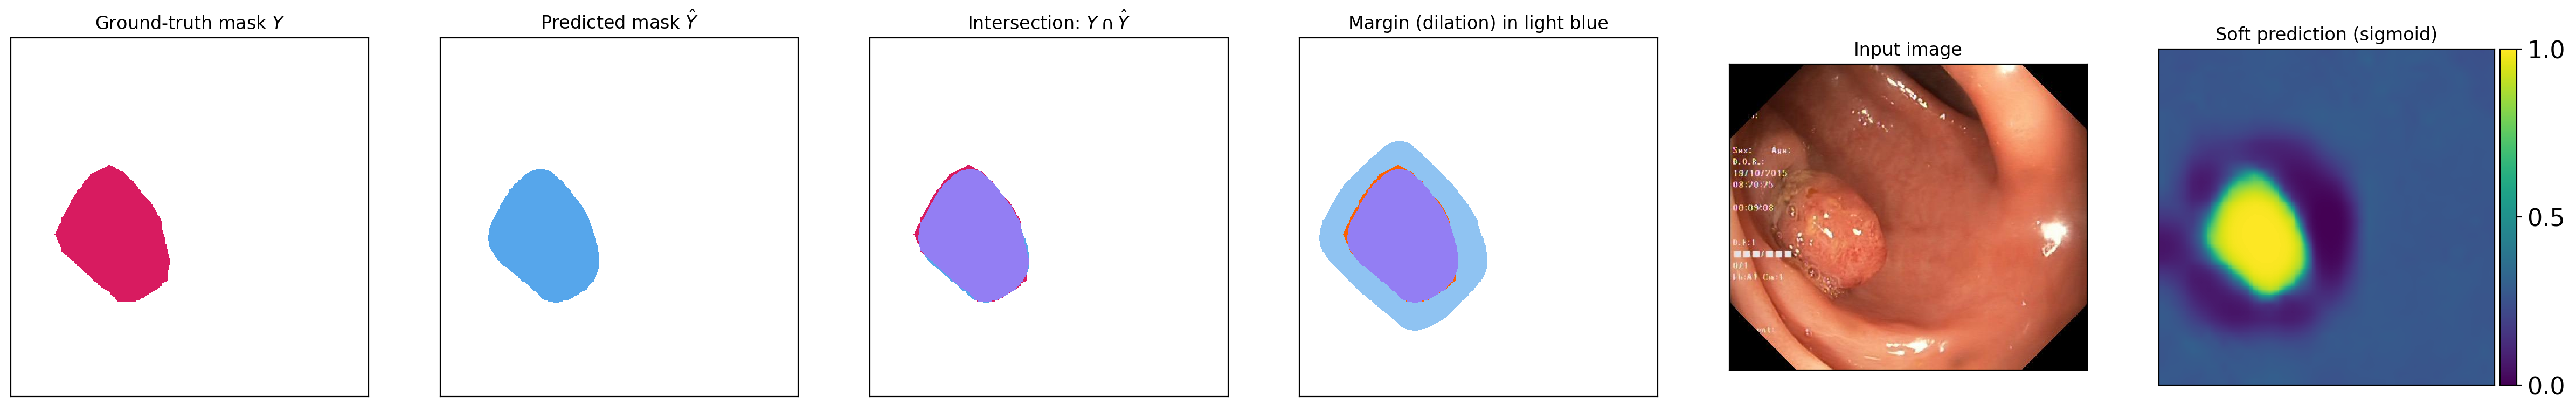

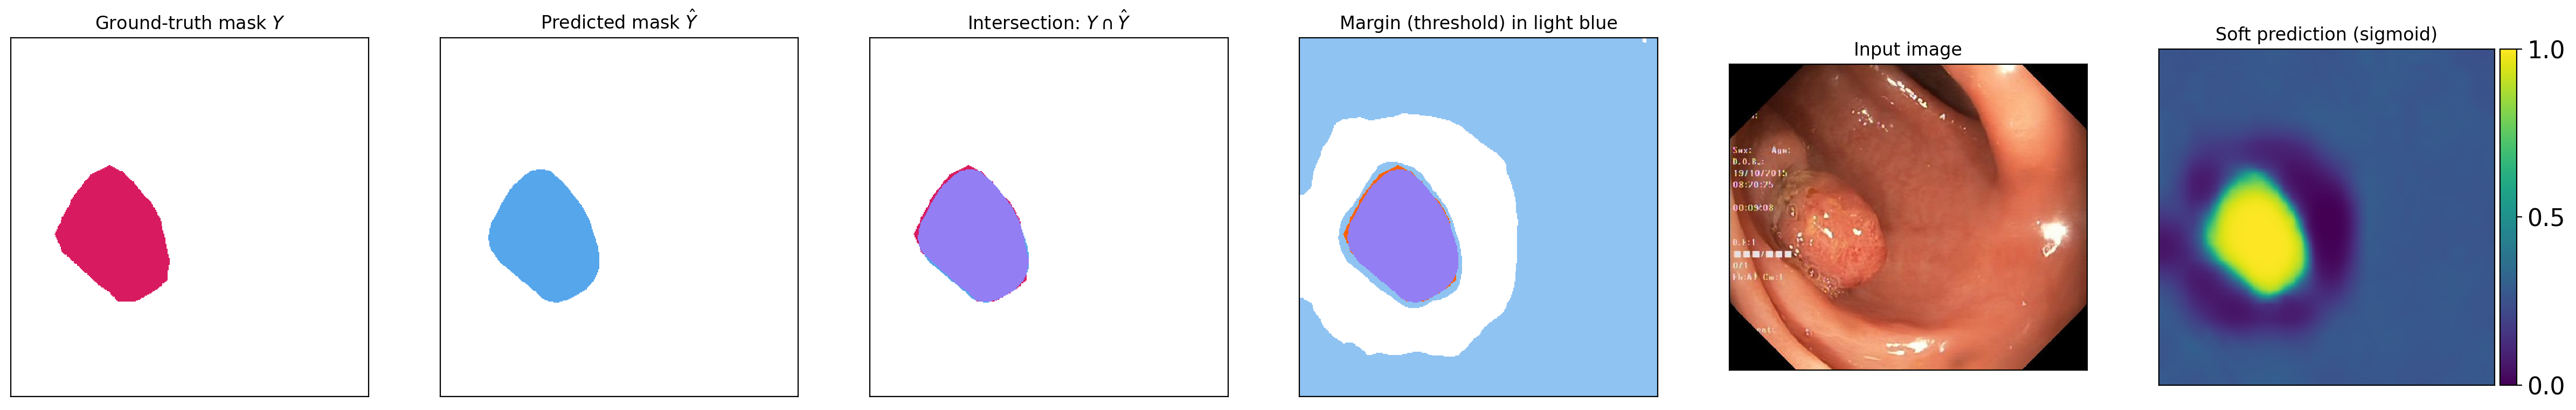

In [ ]:
for idx in range(1):
    test_image = test_images[idx][0]
    input_image = test_image
    test_gt = test_gt_arrays[idx][0]
    test_pred = test_pred_arrays[idx][0]
    hard_pred = test_pred > 0.5

    # Compute the conformal set using the threshold as the conformal quantile
    conformal_n_dilations = cp_quantiles[0]
    conformal_threshold = cp_quantiles[1]

    conformal_sets = [
        operator_dilation_sequential(
            input_mask=hard_pred,
            operator_parameter=conformal_n_dilations,
            se_params_=se_params,
        ),
        # operator_thresholding(pred_softmax=test_pred, operator_parameter=conformal_threshold, se_params_=se_params),
        test_pred > 1 - conformal_threshold,
    ]

    # (1) Fixed disk
    fig_plot_margin_and_recovered(
        predicted_mask=hard_pred,
        ground_truth_mask=test_gt,
        dilated_mask=conformal_sets[0],
        input_image=test_image,
        softprediction=test_pred,
        save_cp_method_name="dilation",
    )

    # (2) threshold disk
    fig_plot_margin_and_recovered(
        predicted_mask=hard_pred,
        ground_truth_mask=test_gt,
        dilated_mask=conformal_sets[1],
        input_image=test_image,
        softprediction=test_pred,
        save_cp_method_name="threshold",
    )